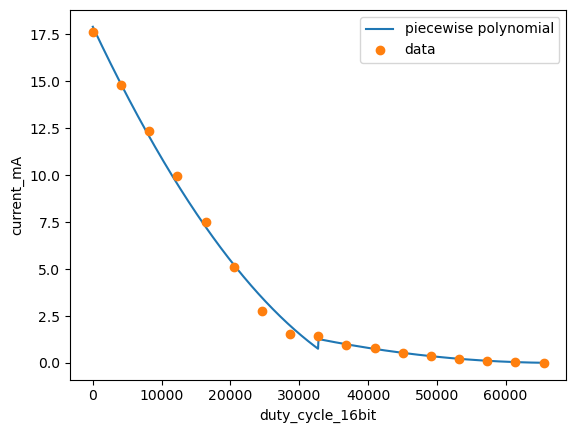

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import root

# Raw data
org_duty_cycle_16bit = np.array([
65520,
61425,
57330,
53235,
49140,
45045,
40950,
36855,
32760,
28665,
24570,
20475,
16380,
12285,
8190,
4095,
0
])

current_mA = np.array([
0.019,
0.042,
0.110,
0.207,
0.371,
0.521,
0.804,
0.963,
1.413,
1.522,
2.764,
5.116,
7.517,
9.930,
12.355,
14.780,
17.608
])

# Identify breakpoint
breakpoint = 32760

# Separate the data into two parts
mask = org_duty_cycle_16bit <= breakpoint
x1 = org_duty_cycle_16bit[mask]
y1 = current_mA[mask]
x2 = org_duty_cycle_16bit[~mask]
y2 = current_mA[~mask]

# Fit a 2nd degree polynomial to each part
p1 = np.polyfit(x1, y1, 2)
p2 = np.polyfit(x2, y2, 2)

# Create a function that uses the appropriate polynomial
def piecewise_poly(x, p1, p2, breakpoint):
    return np.where(x <= breakpoint, np.polyval(p1, x), np.polyval(p2, x))

# Plot the piecewise polynomial function
x = np.linspace(0, 65535, 1000)
y = piecewise_poly(x, p1, p2, breakpoint)
plt.plot(x, y, label='piecewise polynomial')
plt.plot(org_duty_cycle_16bit, current_mA, 'o', label='data')
plt.xlabel('duty_cycle_16bit')
plt.ylabel('current_mA')
plt.legend()
plt.show()



[ 8.57500435e-40 -2.49409276e-34  2.98212588e-29 -1.88006030e-24
  6.64912856e-20 -1.29414029e-15  1.27031015e-11 -4.70500855e-08
 -6.39152356e-04  1.76093249e+01]


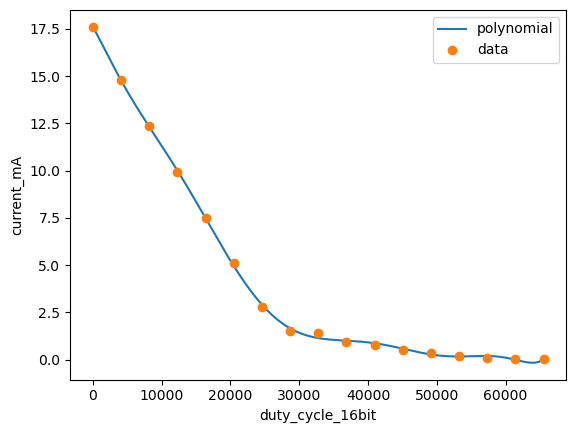

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import root

# Raw data
org_duty_cycle_16bit = np.array([
65520,
61425,
57330,
53235,
49140,
45045,
40950,
36855,
32760,
28665,
24570,
20475,
16380,
12285,
8190,
4095,
0
])

current_mA = np.array([
0.019,
0.042,
0.110,
0.207,
0.371,
0.521,
0.804,
0.963,
1.413,
1.522,
2.764,
5.116,
7.517,
9.930,
12.355,
14.780,
17.608
])

# we find the n-th order polynomial that fits the data
n = 9
p = np.polyfit(org_duty_cycle_16bit, current_mA, n)
print(p)

# plot the polynomial
x = np.linspace(0, 65535, 1000)
y = np.polyval(p, x)
plt.plot(x, y, label='polynomial')
plt.plot(org_duty_cycle_16bit, current_mA, 'o', label='data')
plt.xlabel('duty_cycle_16bit')
plt.ylabel('current_mA')
plt.legend()
plt.show()

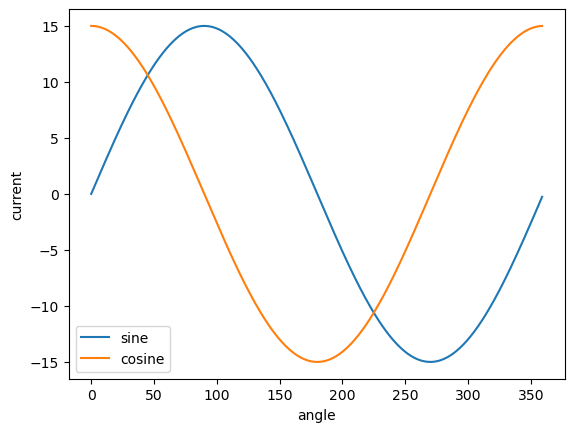

In [3]:
# each angel, has 2 currents associated with it, one for each coil (sine and cosine)
MaxCurrent = 15 # mA
Current = np.zeros((360, 2))
for i in range(360):
    Current[i][0] = MaxCurrent * np.sin(np.deg2rad(i))
    Current[i][1] = MaxCurrent * np.cos(np.deg2rad(i))

# plot the currents
plt.plot(Current[:, 0], label='sine')
plt.plot(Current[:, 1], label='cosine')
# plt.plot(np.arctan(Current[:, 1]/Current[:, 0]), label='arctan(cosine/sine)')
plt.xlabel('angle')
plt.ylabel('current')
plt.legend()
plt.show()

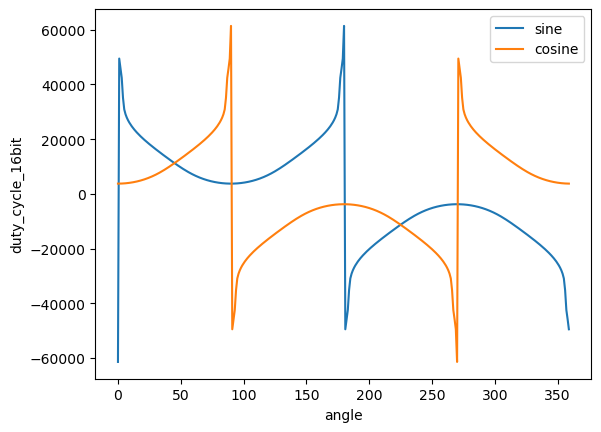

In [4]:
# initial guess for the duty cycle
# you might want to choose a more sensible initial guess
x0 = 0

# Now for each curent, we find the corosponding 16bit duty cycle (make it negative if it is negative)
duty_cycle_16bit = np.zeros((360, 2))
for i in range(360):
    for j in range(2):
        if Current[i][j] > 0:
            # define the function whose root we'll find
            func = lambda x: np.polyval(p, x) - Current[i][j]
            
            # find the root
            sol = root(func, x0)
            
            # ensure the solution has converged
            if sol.success:
                duty_cycle_16bit[i][j] = sol.x[0]
            else:
                print(f"Solution did not find converge for i={i}, j={j}")
        else:
            # define the function whose root we'll find
            func = lambda x: np.polyval(p, x) + Current[i][j]
            
            # find the root
            sol = root(func, x0)
            
            # ensure the solution has converged
            if sol.success:
                duty_cycle_16bit[i][j] = - sol.x[0]
            else:
                print(f"Solution did not find converge for i={i}, j={j}")

# plot the duty cycles
plt.plot(duty_cycle_16bit[:, 0], label='sine')
plt.plot(duty_cycle_16bit[:, 1], label='cosine')
plt.xlabel('angle')
plt.ylabel('duty_cycle_16bit')
plt.legend()
plt.show()

In [5]:
# now we print it a a C array on one line
print("const int duty_cycle_16bit[360][2] = {" , end='')
for i in range(360):
    print("{" + f"{int(duty_cycle_16bit[i][0])}, {int(duty_cycle_16bit[i][1])}" + "},", end='')
print("};")


const int duty_cycle_16bit[360][2] = {{-61393, 3763},{49464, 3767},{45786, 3777},{42427, 3794},{35147, 3818},{30894, 3849},{29147, 3886},{27923, 3931},{26943, 3982},{26108, 4041},{25371, 4106},{24704, 4178},{24089, 4258},{23516, 4345},{22977, 4439},{22465, 4541},{21976, 4650},{21507, 4766},{21054, 4890},{20616, 5022},{20190, 5162},{19775, 5310},{19369, 5465},{18972, 5630},{18583, 5802},{18200, 5983},{17823, 6172},{17451, 6370},{17084, 6576},{16721, 6791},{16361, 7015},{16005, 7247},{15652, 7488},{15301, 7737},{14953, 7994},{14607, 8259},{14263, 8532},{13921, 8811},{13580, 9098},{13242, 9391},{12906, 9690},{12571, 9994},{12239, 10304},{11909, 10617},{11581, 10935},{11257, 11257},{10935, 11581},{10617, 11909},{10304, 12239},{9994, 12571},{9690, 12906},{9391, 13242},{9098, 13580},{8811, 13921},{8532, 14263},{8259, 14607},{7994, 14953},{7737, 15301},{7488, 15652},{7247, 16005},{7015, 16361},{6791, 16721},{6576, 17084},{6370, 17451},{6172, 17823},{5983, 18200},{5802, 18583},{5630, 18972},{5

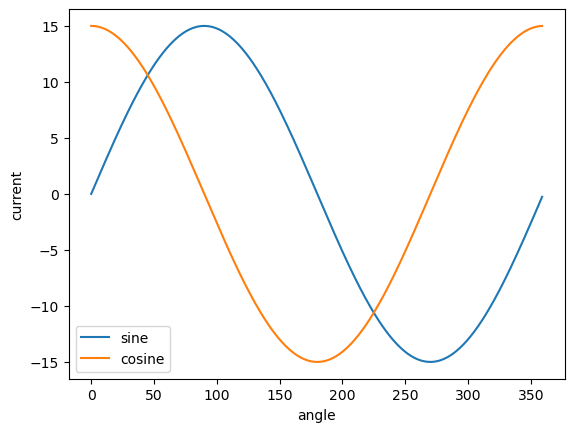

In [6]:
# now we are going to check this LUT by using it to generate a sine wave
# so for every degree, we will set the duty cycle to the value in the LUT, and then calculate the current with the p polynomial

calcCurrent = np.zeros((360, 2))
for i in range(360):
    for j in range(2):
        # calculate the current
        if duty_cycle_16bit[i][j] > 0:
            calcCurrent[i][j] = np.polyval(p, duty_cycle_16bit[i][j])
        else:
            calcCurrent[i][j] = - np.polyval(p, - duty_cycle_16bit[i][j])

# plot the currents
plt.plot(calcCurrent[:, 0], label='sine')
plt.plot(calcCurrent[:, 1], label='cosine')
# # also plot the original currents
# plt.plot(Current[:, 0], label='sine original')
# plt.plot(Current[:, 1], label='cosine original')
plt.xlabel('angle')
plt.ylabel('current')
plt.legend()
plt.show()